In [30]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm

from typing import List
from collections import Counter
from itertools import chain
import umap.umap_ as umap
import matplotlib.pyplot as plt
import torch

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer

from gensim.models import Word2Vec

def filtered_text(text):
    return list(filter(lambda word: word in cleaned_words, text.split()))

def build_vocab(reviews: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in reviews]))
    vocab = Counter(words)
    return vocab

def make_word_embedding(word: str) -> torch.Tensor:
    
    tokens = tokenizer.tokenize(word)
    ind = tokenizer.convert_tokens_to_ids(tokens)
    segments_ids = [1] * len(ind)
    outputs = model_bert(torch.tensor([ind]), torch.tensor([segments_ids]))
    return outputs[2][-1].squeeze(0).sum(dim=0).tolist()

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    cleaned_words = []
    for word in text.split():
        if word in eng_stopwords:
            continue
        cleaned_words.append(stemmer.stem(word))

    return ' '.join(cleaned_words)




class Utils:
    
    def __init__(self, words, word_to_vec_f):
        self.words_dict = dict(zip(words, range(len(words))))
        self.converter = word_to_vec_f
        self.cosin_matrix = self.build_cosine_matrix(words, word_to_vec_f)
        
    def get_embed(self, word):
        return self.converter(word)
        
    def build_cosine_matrix(self, words, func):
        np_words = np.array([func(word) for word in tqdm(words)])
        return cosine_similarity(np_words, np_words)

    def common(self, word1, word2, f):
        a, b = np.array(self.converter(word1)), np.array(self.converter(word2))
        return f(a, b)
    
    def subwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a+b)

    def sumwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a+b)
    
    def similar_helper(self, vector):
        temp = [(w, cosine_similarity([self.converter(w)], [vector])[0][0]) for w in self.words_dict.keys()]
        temp.sort(key=lambda x:-x[1])
        return temp
    
    def similar(self, vector, count=1):
        temp = self.similar_helper(vector)
        return temp[2:2+count]
    
    def unsimilar(self, vector, count=1):
        temp = self.similar_helper(word)
        return sorted(temp[-count-2:-2], key=lambda x: x[1])
    
    def close_helper(self, word):
        word_index = self.words_dict[word]
        temp = [(i, w, self.cosin_matrix[word_index][i]) for w, i in filter(lambda x: x[0] != word, self.words_dict.items())]
        temp.sort(key=lambda x:-x[2])
        return temp
    
    def close(self, word, count=1):
        temp = self.close_helper(word)
        return temp[:count]
    
    def unclose(self, word, count=1):
        temp = self.close_helper(word)
        return sorted(temp[-count:], key=lambda x: x[2])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df1 = pd.read_csv('shopee_reviews.csv')
df1.columns = ['marking', 'review']

In [32]:
res = pd.DataFrame(columns=['marking', 'review'])
for mark in range(1, 5 + 1):
    res = res.append(df1[df1.marking == marking].sample(10000), ignore_index=True)
df1 = res
vocab = build_vocab(df1.review.tolist())
print(len(vocab))
list(vocab.items())[:10]

37069


[('Item', 4906),
 ('received', 7316),
 ('in', 14045),
 ('good', 14567),
 ('condition..Thank', 1),
 ('u', 590),
 ('so', 3150),
 ('much!!', 33),
 ('Worth', 630),
 ('the', 20897)]

In [33]:
eng_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [34]:
texts = []
for text in tqdm(df1.review.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(10)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:15<00:00, 3205.39it/s]


13765


[('good', 22184),
 ('receiv', 14711),
 ('deliveri', 14220),
 ('fast', 11808),
 ('item', 11588),
 ('thank', 8504),
 ('condit', 7688),
 ('well', 7531),
 ('seller', 7415),
 ('nice', 6418)]

In [35]:
cleaner = list(filter(lambda x: x[1] > 3, vocab.items()))
cleaned_words = [k for k, v in cleaner]
print(len(cleaned_words))
for i in range (10):
    print(cleaned_words[i])

3664
item
receiv
good
conditionthank
u
much
worth
money
shoe
comfort


In [36]:
model = Word2Vec(sentences=[filtered_text(text) for text in tqdm(texts)],
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=40, 
                 min_count=1
                 )
print('Size of the vector', model.wv.vectors.shape)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:08<00:00, 6020.85it/s]


Size of the vector (3664, 100)


In [37]:
dots = umap.UMAP(random_state=42).fit_transform(model.wv.vectors[:500])

AxesSubplot(0.125,0.125;0.775x0.755)


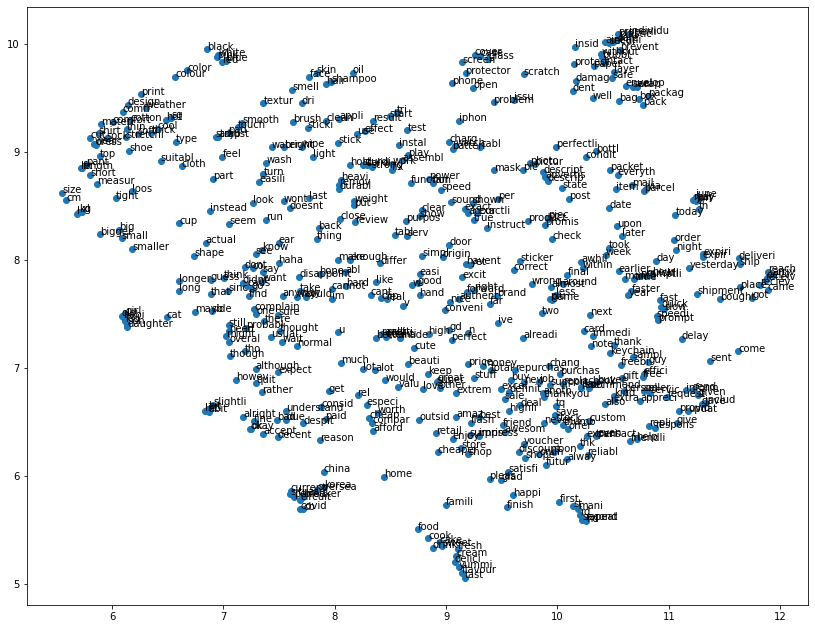

In [38]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(dots[:, 0], dots[:, 1])
print(ax)

for i, txt in enumerate(model.wv.index_to_key[:500]):
    ax.annotate(txt, (dots[i, 0], dots[i, 1]))

In [39]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_bert = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True,)
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [40]:
bert = Utils(cleaned_words, make_word_embedding)
gensim = Utils(cleaned_words, model.wv.get_vector)

100%|███████████████████████████████████████████████████████████████████████████| 3664/3664 [00:00<00:00, 19840.08it/s]


In [44]:
gensim.sumwords("green", "blue")


array([-0.416103  , -3.0912952 , -2.6004708 , -1.6948357 , -1.0842224 ,
        4.5764885 ,  6.8416944 , -0.16956337,  2.234455  , -4.456154  ,
       -0.12999941, -2.910894  , -3.7495532 ,  1.8417941 , -0.7647927 ,
       -2.2208862 , -0.8205633 ,  0.03616306,  1.0078593 ,  0.3982932 ,
        1.7250125 , -0.700721  ,  0.5338348 ,  1.6420965 , -1.6740158 ,
        1.5958416 , -1.719985  ,  3.3691611 ,  1.6052003 , -2.2110693 ,
        1.5253218 , -0.5729572 ,  0.0711211 , -3.5844197 , -0.7078767 ,
        0.25265136, -3.335757  ,  5.211608  ,  2.0735269 , -2.6193027 ,
       -2.1384037 , -0.26709002,  0.5966815 ,  0.60409474,  2.9290328 ,
       -4.597452  , -0.47421294, -0.14445096, -0.05688572,  0.7257916 ,
       -1.7575634 ,  0.25264186,  0.11858869, -1.5962294 , -1.9203892 ,
       -1.6867123 ,  0.85872996, -1.1744126 ,  0.30409142, -1.779067  ,
        0.8786154 ,  2.1844819 ,  0.80813956,  2.8769064 , -0.18976161,
       -2.5487075 ,  1.6019926 , -1.3065083 , -0.33018044, -1.59

In [59]:
bert.sumwords("green", "blue")

array([-2.03892063e-01, -3.25684547e-02, -1.65935534e+00,  4.32033606e-01,
        1.07169271e-01,  2.94318128e-01,  1.46816164e+00,  1.61791277e+00,
       -1.03367770e+00, -2.32867002e-02, -6.06436580e-02, -1.72204322e+00,
       -9.33522224e-01,  2.94937283e-01, -2.77580556e-01,  1.59479356e+00,
        9.20780465e-01, -4.81475472e-01, -2.61451349e-01, -6.39876306e-01,
        4.63206291e-01, -1.19270357e+00, -2.72330344e-01,  6.39162660e-02,
       -4.17432502e-01, -7.71861613e-01, -4.24021706e-01, -6.67046532e-02,
       -6.62748575e-01, -5.25288522e-01,  3.87873560e-01, -1.03554845e+00,
        1.69460356e-01, -5.36632925e-01,  4.98875767e-01,  1.93465817e+00,
        1.30996197e-01, -9.09210384e-01, -1.46233422e+00, -4.48303446e-01,
        1.93115324e-01, -2.18484588e-01, -6.38123259e-01,  2.37202018e-01,
        5.40071607e-01,  6.23127520e-01,  1.34346002e+00,  1.77014410e-01,
       -1.82514511e-01, -7.38514319e-01,  4.30147499e-02,  1.18255365e+00,
        1.18185103e+00, -

In [50]:
gensim.similar(gensim.subwords("good", "fast"), count = 5)

[('good', 0.64851904),
 ('prompt', 0.55573606),
 ('speedi', 0.5127396),
 ('promptli', 0.49426055),
 ('slow', 0.47696328)]

In [61]:
bert.similar(bert.subwords("good", "fast"), count = 5)

KeyboardInterrupt: 

In [52]:
gensim.close("good", count=10)

[(76, 'great', 0.6023845),
 (819, 'gd', 0.52071303),
 (234, 'bad', 0.5071022),
 (932, 'decent', 0.46413803),
 (153, 'ok', 0.464087),
 (248, 'okay', 0.4533098),
 (498, 'accept', 0.4074351),
 (134, 'excel', 0.40466154),
 (193, 'perfect', 0.3821136),
 (77, 'nice', 0.3439272)]

In [54]:
bert.close("good", count=10)

[(3291, 'goodwil', 0.834640761366829),
 (2263, 'goodi', 0.8302487314543588),
 (2289, 'goodthank', 0.7717763605899831),
 (2965, 'goodgood', 0.7717021360349129),
 (3278, 'goodfast', 0.7462028456357318),
 (2404, 'goodbut', 0.7310776725865363),
 (1728, 'vid', 0.7208078108302536),
 (120, 'goodveri', 0.7158313568305109),
 (3100, 'bird', 0.7120668525109795),
 (1202, 'dish', 0.7116313000290836)]

In [ ]:
corpus_vocab = sorted(cleaned_vocab, key=lambda x: -x[1])[:2000]
print(corpus_vocab[:10])
corpus = [i[0] for i in corpus_vocab]

TypeError: bad operand type for unary -: 'str'

In [62]:
embeddings = [gensim.get_embed(i) for i in corpus]
print(embeddings[0])

NameError: name 'corpus' is not defined

In [43]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

writer.add_embedding(embeddings,metadata=corpus)
writer.close()

In [44]:
%load_ext tensorboard

In [47]:
%tensorboard --logdir runs --bind_all --port 7012

Reusing TensorBoard on port 7012 (pid 24216), started 0:00:33 ago. (Use '!kill 24216' to kill it.)